In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
from typing import Dict
import pandas as pd

In [3]:
import run_sampler, models, data_utils

/Users/mandar/.venvs/covid/lib/python3.8/site-packages/prettyprinter/__init__.py:337: UserWarning: Failed to install 'python' PrettyPrinter extra. If you don't need it, call install_extras with exclude=['python']
  warnings.warn(


In [4]:
state = "Kerala" # "Maharashtra"
MH_pop = 34800000  # 112374333
start_date = datetime.datetime(2021, 1, 1)

In [5]:
analysis = run_sampler.tuning_exp(
    state,
    MH_pop,
    start_date=start_date,
    num_samples=100
)

2021-05-05 20:22:16,423	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265
2021-05-05 20:22:18,371	WARNING function_runner.py:544 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho
_tuning_fn_d33d3_00000,RUNNING,,0.944388,0.181425,0.00840968,0.486631,0.0307007,0.441216,0.000789902
_tuning_fn_d33d3_00001,PENDING,,1.05872,0.115558,0.00217073,0.611555,0.0354983,0.620111,0.000642666
_tuning_fn_d33d3_00002,PENDING,,0.713357,0.175455,0.00120656,0.280812,0.00632959,0.440444,0.000700981
_tuning_fn_d33d3_00003,PENDING,,1.13405,0.315142,0.00284084,0.598033,0.00646346,0.49461,0.000898576
_tuning_fn_d33d3_00004,PENDING,,0.793429,0.10968,0.0254708,0.691482,0.00891726,0.613917,0.000103334
_tuning_fn_d33d3_00005,PENDING,,1.12776,0.17202,0.0147932,0.348145,0.00547024,0.427125,0.000181316
_tuning_fn_d33d3_00006,PENDING,,1.0544,0.263294,0.00104884,0.602742,0.0233383,0.694475,0.000702443
_tuning_fn_d33d3_00007,PENDING,,1.19351,0.201336,0.0130327,0.479443,0.0385812,0.635799,0.000173928
_tuning_fn_d33d3_00008,PENDING,,1.11771,0.236025,0.0247134,0.289609,0.0255128,0.702029,0.000354926
_tuning_fn_d33d3_00009,PENDING,,0.721416,0.220952,0.00134019,0.663678,0.00533283,0.773712,0.000254732


Result for _tuning_fn_d33d3_00000:
  date: 2021-05-05_20-22-20
  done: false
  experiment_id: 0f5abfb6461d4e12a02e9baf5ffc93d4
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.3390195096242503
  node_ip: 192.168.192.62
  pid: 8086
  time_since_restore: 0.07581806182861328
  time_this_iter_s: 0.07581806182861328
  time_total_s: 0.07581806182861328
  timestamp: 1620238940
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00000
  
Result for _tuning_fn_d33d3_00000:
  date: 2021-05-05_20-22-20
  done: true
  experiment_id: 0f5abfb6461d4e12a02e9baf5ffc93d4
  experiment_tag: 0_beta=0.94439,eps=0.18142,mu=0.0084097,p_a=0.48663,p_d=0.030701,r_b=0.44122,rho=0.0007899
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.3390195096242503
  node_ip: 192.168.192.62
  pid: 8086
  time_since_restore: 0.07581806182861328
  time_this_iter_s: 0.07581806182861328
  time_total_s: 0.07581806182861328
  timestamp: 1620238940
  ti

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_d33d3_00008,RUNNING,,1.11771,0.236025,0.0247134,0.289609,0.0255128,0.702029,0.000354926,,,
_tuning_fn_d33d3_00009,RUNNING,,0.721416,0.220952,0.00134019,0.663678,0.00533283,0.773712,0.000254732,,,
_tuning_fn_d33d3_00010,RUNNING,,0.892225,0.170591,0.00511273,0.441557,0.0435625,0.674847,0.000201193,,,
_tuning_fn_d33d3_00011,RUNNING,,0.897393,0.076287,0.00102937,0.43713,0.00891919,0.324805,0.00075794,,,
_tuning_fn_d33d3_00012,RUNNING,,0.630353,0.134756,0.0154049,0.276287,0.0105473,0.320342,0.000145449,,,
_tuning_fn_d33d3_00013,RUNNING,,1.03414,0.0984833,0.0222717,0.475982,0.0144708,0.428269,0.000112245,,,
_tuning_fn_d33d3_00014,RUNNING,,1.05276,0.256685,0.0487326,0.575533,0.00658236,0.673432,0.000101993,,,
_tuning_fn_d33d3_00016,PENDING,,1.15532,0.261717,0.0323144,0.635269,0.00506634,0.565144,0.000534526,,,
_tuning_fn_d33d3_00017,PENDING,,0.869158,0.157111,0.010933,0.635886,0.00610857,0.5541,0.000133599,,,
_tuning_fn_d33d3_00018,PENDING,,0.730167,0.0807037,0.00422522,0.468177,0.00721395,0.70697,0.000893446,,,


Result for _tuning_fn_d33d3_00015:
  date: 2021-05-05_20-22-25
  done: false
  experiment_id: 106762a061084404a8ce9159286e01eb
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.4132946299473677
  node_ip: 192.168.192.62
  pid: 8097
  time_since_restore: 0.08606576919555664
  time_this_iter_s: 0.08606576919555664
  time_total_s: 0.08606576919555664
  timestamp: 1620238945
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00015
  
Result for _tuning_fn_d33d3_00015:
  date: 2021-05-05_20-22-25
  done: true
  experiment_id: 106762a061084404a8ce9159286e01eb
  experiment_tag: 15_beta=0.79093,eps=0.28593,mu=0.0069499,p_a=0.5331,p_d=0.019026,r_b=0.42017,rho=0.00012223
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.4132946299473677
  node_ip: 192.168.192.62
  pid: 8097
  time_since_restore: 0.08606576919555664
  time_this_iter_s: 0.08606576919555664
  time_total_s: 0.08606576919555664
  timestamp: 1620238945
  t

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_d33d3_00016,RUNNING,,1.15532,0.261717,0.0323144,0.635269,0.00506634,0.565144,0.000534526,,,
_tuning_fn_d33d3_00017,RUNNING,,0.869158,0.157111,0.010933,0.635886,0.00610857,0.5541,0.000133599,,,
_tuning_fn_d33d3_00018,RUNNING,,0.730167,0.0807037,0.00422522,0.468177,0.00721395,0.70697,0.000893446,,,
_tuning_fn_d33d3_00019,RUNNING,,1.09863,0.169765,0.00180141,0.430011,0.00832809,0.766502,0.000126456,,,
_tuning_fn_d33d3_00020,RUNNING,,0.633082,0.302306,0.0104027,0.460469,0.0332999,0.435902,0.000293122,,,
_tuning_fn_d33d3_00021,RUNNING,,0.883203,0.125211,0.00344531,0.505898,0.0269003,0.561504,0.000850566,,,
_tuning_fn_d33d3_00022,RUNNING,192.168.192.62:8131,0.707506,0.0907378,0.00111635,0.525666,0.0319359,0.762759,0.000542384,1,0.0865607,2.22247
_tuning_fn_d33d3_00024,PENDING,,1.05564,0.278732,0.00195041,0.469453,0.00886815,0.435641,0.000521851,,,
_tuning_fn_d33d3_00025,PENDING,,0.98067,0.119104,0.0327495,0.260478,0.0147489,0.366596,0.000334234,,,
_tuning_fn_d33d3_00026,PENDING,,1.17737,0.238749,0.0217731,0.478722,0.00695769,0.72482,0.000302318,,,


Result for _tuning_fn_d33d3_00016:
  date: 2021-05-05_20-22-31
  done: false
  experiment_id: c5d6a2b945434c1f9547a1432c175946
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.5981665476397633
  node_ip: 192.168.192.62
  pid: 8139
  time_since_restore: 0.08673810958862305
  time_this_iter_s: 0.08673810958862305
  time_total_s: 0.08673810958862305
  timestamp: 1620238951
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00016
  
Result for _tuning_fn_d33d3_00016:
  date: 2021-05-05_20-22-31
  done: true
  experiment_id: c5d6a2b945434c1f9547a1432c175946
  experiment_tag: 16_beta=1.1553,eps=0.26172,mu=0.032314,p_a=0.63527,p_d=0.0050663,r_b=0.56514,rho=0.00053453
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.5981665476397633
  node_ip: 192.168.192.62
  pid: 8139
  time_since_restore: 0.08673810958862305
  time_this_iter_s: 0.08673810958862305
  time_total_s: 0.08673810958862305
  timestamp: 1620238951
  t

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_d33d3_00024,RUNNING,,1.05564,0.278732,0.00195041,0.469453,0.00886815,0.435641,0.000521851,,,
_tuning_fn_d33d3_00025,RUNNING,,0.98067,0.119104,0.0327495,0.260478,0.0147489,0.366596,0.000334234,,,
_tuning_fn_d33d3_00026,RUNNING,,1.17737,0.238749,0.0217731,0.478722,0.00695769,0.72482,0.000302318,,,
_tuning_fn_d33d3_00027,RUNNING,,0.851001,0.327035,0.0325593,0.296742,0.0235026,0.742727,0.000226267,,,
_tuning_fn_d33d3_00028,RUNNING,,0.947509,0.327296,0.0453841,0.407575,0.0168845,0.585991,0.000169932,,,
_tuning_fn_d33d3_00029,RUNNING,,0.758776,0.0976873,0.00651771,0.61967,0.0350141,0.719071,0.000146183,,,
_tuning_fn_d33d3_00030,RUNNING,,1.06419,0.248242,0.00664034,0.646359,0.00780667,0.569,0.000272867,,,
_tuning_fn_d33d3_00032,PENDING,,0.632325,0.269864,0.00218336,0.324898,0.0176415,0.351391,0.000486566,,,
_tuning_fn_d33d3_00033,PENDING,,0.978678,0.256317,0.0101287,0.487264,0.00552298,0.510761,0.00057195,,,
_tuning_fn_d33d3_00034,PENDING,,1.07372,0.275432,0.0376952,0.580917,0.0337443,0.423467,0.000683852,,,


Result for _tuning_fn_d33d3_00031:
  date: 2021-05-05_20-22-36
  done: true
  experiment_id: 51d00febd3264407838d42ec69af60c9
  experiment_tag: 31_beta=0.64347,eps=0.12366,mu=0.0084479,p_a=0.62933,p_d=0.0069617,r_b=0.73369,rho=0.00046323
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.079024853652829
  node_ip: 192.168.192.62
  pid: 8165
  time_since_restore: 0.08479714393615723
  time_this_iter_s: 0.08479714393615723
  time_total_s: 0.08479714393615723
  timestamp: 1620238956
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00031
  
Result for _tuning_fn_d33d3_00030:
  date: 2021-05-05_20-22-36
  done: false
  experiment_id: dd698b9780f744559476206766ab36da
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.51741436636431
  node_ip: 192.168.192.62
  pid: 8167
  time_since_restore: 0.09055590629577637
  time_this_iter_s: 0.09055590629577637
  time_total_s: 0.09055590629577637
  timestamp: 1620238956
  ti

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_d33d3_00032,RUNNING,,0.632325,0.269864,0.00218336,0.324898,0.0176415,0.351391,0.000486566,,,
_tuning_fn_d33d3_00033,RUNNING,,0.978678,0.256317,0.0101287,0.487264,0.00552298,0.510761,0.00057195,,,
_tuning_fn_d33d3_00034,RUNNING,,1.07372,0.275432,0.0376952,0.580917,0.0337443,0.423467,0.000683852,,,
_tuning_fn_d33d3_00035,RUNNING,,0.907899,0.0931176,0.0262915,0.345294,0.0187429,0.78463,0.000726113,,,
_tuning_fn_d33d3_00036,RUNNING,,0.620186,0.228092,0.0179253,0.471486,0.0413702,0.70934,0.000225427,,,
_tuning_fn_d33d3_00037,RUNNING,,0.847512,0.131158,0.0151932,0.342746,0.024373,0.686644,0.000524406,,,
_tuning_fn_d33d3_00038,RUNNING,,0.767859,0.127027,0.00337571,0.316778,0.0202475,0.340475,0.000788804,,,
_tuning_fn_d33d3_00040,PENDING,,0.751181,0.148962,0.00175903,0.554158,0.00770176,0.418639,0.000876812,,,
_tuning_fn_d33d3_00041,PENDING,,0.836811,0.182788,0.00172272,0.519182,0.0224501,0.764642,0.00018209,,,
_tuning_fn_d33d3_00042,PENDING,,1.08972,0.0714427,0.03984,0.412972,0.00930003,0.64928,0.000195694,,,


Result for _tuning_fn_d33d3_00038:
  date: 2021-05-05_20-22-42
  done: false
  experiment_id: fbf8b718732e4359a2cdf84d0d17d274
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.226754976236908
  node_ip: 192.168.192.62
  pid: 8205
  time_since_restore: 0.09894180297851562
  time_this_iter_s: 0.09894180297851562
  time_total_s: 0.09894180297851562
  timestamp: 1620238962
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00038
  
Result for _tuning_fn_d33d3_00039:
  date: 2021-05-05_20-22-42
  done: true
  experiment_id: dbc38acbc8b442eca409b868a534937e
  experiment_tag: 39_beta=0.83398,eps=0.32051,mu=0.012579,p_a=0.49544,p_d=0.0069785,r_b=0.73962,rho=0.00026299
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.500974915252969
  node_ip: 192.168.192.62
  pid: 8201
  time_since_restore: 0.1129307746887207
  time_this_iter_s: 0.1129307746887207
  time_total_s: 0.1129307746887207
  timestamp: 1620238962
  times

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_d33d3_00040,RUNNING,,0.751181,0.148962,0.00175903,0.554158,0.00770176,0.418639,0.000876812,,,
_tuning_fn_d33d3_00041,RUNNING,,0.836811,0.182788,0.00172272,0.519182,0.0224501,0.764642,0.00018209,,,
_tuning_fn_d33d3_00042,RUNNING,,1.08972,0.0714427,0.03984,0.412972,0.00930003,0.64928,0.000195694,,,
_tuning_fn_d33d3_00043,RUNNING,,1.04486,0.0870921,0.00646686,0.436082,0.0125813,0.531032,0.000372857,,,
_tuning_fn_d33d3_00044,RUNNING,,1.04644,0.13505,0.0166784,0.36886,0.0110889,0.330962,0.000859081,,,
_tuning_fn_d33d3_00045,RUNNING,,0.863302,0.172836,0.0493399,0.571119,0.00664192,0.768247,0.000306018,,,
_tuning_fn_d33d3_00046,RUNNING,192.168.192.62:8234,1.18838,0.187314,0.0015609,0.454575,0.00730456,0.612068,0.000159466,1,0.0893528,2.7046
_tuning_fn_d33d3_00048,PENDING,,0.956784,0.26756,0.0137602,0.490946,0.016147,0.513358,0.000190521,,,
_tuning_fn_d33d3_00049,PENDING,,0.739236,0.120228,0.0185576,0.554159,0.00576877,0.385672,0.000889232,,,
_tuning_fn_d33d3_00050,PENDING,,1.14039,0.14062,0.0356066,0.548773,0.0110635,0.762816,0.000227664,,,


Result for _tuning_fn_d33d3_00046:
  date: 2021-05-05_20-22-47
  done: true
  experiment_id: 3484154bd52a4fa88504fd5e42713bc8
  experiment_tag: 46_beta=1.1884,eps=0.18731,mu=0.0015609,p_a=0.45458,p_d=0.0073046,r_b=0.61207,rho=0.00015947
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.7046022284574978
  node_ip: 192.168.192.62
  pid: 8234
  time_since_restore: 0.08935284614562988
  time_this_iter_s: 0.08935284614562988
  time_total_s: 0.08935284614562988
  timestamp: 1620238967
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00046
  
Result for _tuning_fn_d33d3_00047:
  date: 2021-05-05_20-22-47
  done: false
  experiment_id: ffdaeac27f92404ebc7ec15ace12373c
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.5488189924122997
  node_ip: 192.168.192.62
  pid: 8232
  time_since_restore: 0.13411808013916016
  time_this_iter_s: 0.13411808013916016
  time_total_s: 0.13411808013916016
  timestamp: 1620238967
  

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_d33d3_00048,RUNNING,,0.956784,0.26756,0.0137602,0.490946,0.016147,0.513358,0.000190521,,,
_tuning_fn_d33d3_00049,RUNNING,,0.739236,0.120228,0.0185576,0.554159,0.00576877,0.385672,0.000889232,,,
_tuning_fn_d33d3_00050,RUNNING,,1.14039,0.14062,0.0356066,0.548773,0.0110635,0.762816,0.000227664,,,
_tuning_fn_d33d3_00051,RUNNING,,1.07833,0.195734,0.00440884,0.567274,0.0102286,0.577357,0.000409647,,,
_tuning_fn_d33d3_00052,RUNNING,,1.06597,0.328495,0.0117555,0.425695,0.00505479,0.552138,0.00033376,,,
_tuning_fn_d33d3_00053,RUNNING,,1.06241,0.311693,0.00373569,0.589433,0.00608373,0.390519,0.000895851,,,
_tuning_fn_d33d3_00054,RUNNING,192.168.192.62:8268,1.03558,0.176323,0.00695008,0.418492,0.0361894,0.546767,0.000547289,1,0.095053,2.42089
_tuning_fn_d33d3_00056,PENDING,,1.06271,0.278732,0.00570493,0.414626,0.00567585,0.543387,0.000450354,,,
_tuning_fn_d33d3_00057,PENDING,,0.81372,0.122182,0.00123522,0.675721,0.0135825,0.738161,0.000566506,,,
_tuning_fn_d33d3_00058,PENDING,,0.633117,0.226599,0.00571927,0.523062,0.0411361,0.433793,0.000202959,,,


Result for _tuning_fn_d33d3_00051:
  date: 2021-05-05_20-22-52
  done: false
  experiment_id: 61667318c7a14cc58f84daef234ff874
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.5227026729588555
  node_ip: 192.168.192.62
  pid: 8272
  time_since_restore: 0.09630584716796875
  time_this_iter_s: 0.09630584716796875
  time_total_s: 0.09630584716796875
  timestamp: 1620238972
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00051
  
Result for _tuning_fn_d33d3_00054:
  date: 2021-05-05_20-22-52
  done: true
  experiment_id: f43dbeb11078436f863054ab513b3908
  experiment_tag: 54_beta=1.0356,eps=0.17632,mu=0.0069501,p_a=0.41849,p_d=0.036189,r_b=0.54677,rho=0.00054729
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.420893818953048
  node_ip: 192.168.192.62
  pid: 8268
  time_since_restore: 0.09505295753479004
  time_this_iter_s: 0.09505295753479004
  time_total_s: 0.09505295753479004
  timestamp: 1620238972
  ti

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_d33d3_00056,RUNNING,,1.06271,0.278732,0.00570493,0.414626,0.00567585,0.543387,0.000450354,,,
_tuning_fn_d33d3_00057,RUNNING,,0.81372,0.122182,0.00123522,0.675721,0.0135825,0.738161,0.000566506,,,
_tuning_fn_d33d3_00058,RUNNING,,0.633117,0.226599,0.00571927,0.523062,0.0411361,0.433793,0.000202959,,,
_tuning_fn_d33d3_00059,RUNNING,,1.1168,0.0743576,0.0019156,0.577394,0.0142009,0.49201,0.000622742,,,
_tuning_fn_d33d3_00060,RUNNING,,0.911577,0.0900307,0.0123915,0.630883,0.00982049,0.529938,0.000987178,,,
_tuning_fn_d33d3_00061,RUNNING,,1.01026,0.141848,0.0277514,0.347572,0.0129037,0.542407,0.000173666,,,
_tuning_fn_d33d3_00062,RUNNING,,0.735786,0.238999,0.0132962,0.459509,0.0124633,0.432021,0.000437585,,,
_tuning_fn_d33d3_00064,PENDING,,0.765987,0.184,0.0167808,0.513612,0.0192366,0.667452,0.00073616,,,
_tuning_fn_d33d3_00065,PENDING,,0.979689,0.0952953,0.0413326,0.406879,0.0250453,0.650681,0.000105904,,,
_tuning_fn_d33d3_00066,PENDING,,0.683196,0.308584,0.0381805,0.325102,0.0119727,0.676726,0.000108543,,,


Result for _tuning_fn_d33d3_00063:
  date: 2021-05-05_20-22-58
  done: true
  experiment_id: fab01ca1913340379705d857aeeb4a3b
  experiment_tag: 63_beta=0.99865,eps=0.30244,mu=0.018198,p_a=0.48962,p_d=0.011642,r_b=0.33725,rho=0.00068506
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.4616644240395713
  node_ip: 192.168.192.62
  pid: 8302
  time_since_restore: 0.09937214851379395
  time_this_iter_s: 0.09937214851379395
  time_total_s: 0.09937214851379395
  timestamp: 1620238978
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00063
  
Result for _tuning_fn_d33d3_00062:
  date: 2021-05-05_20-22-58
  done: false
  experiment_id: 93282cf6072c438e8a2e7c12cde19bd9
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.292248059104739
  node_ip: 192.168.192.62
  pid: 8305
  time_since_restore: 0.11471009254455566
  time_this_iter_s: 0.11471009254455566
  time_total_s: 0.11471009254455566
  timestamp: 1620238978
  ti

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_d33d3_00064,RUNNING,,0.765987,0.184,0.0167808,0.513612,0.0192366,0.667452,0.00073616,,,
_tuning_fn_d33d3_00065,RUNNING,,0.979689,0.0952953,0.0413326,0.406879,0.0250453,0.650681,0.000105904,,,
_tuning_fn_d33d3_00066,RUNNING,,0.683196,0.308584,0.0381805,0.325102,0.0119727,0.676726,0.000108543,,,
_tuning_fn_d33d3_00067,RUNNING,,0.632234,0.292617,0.00282233,0.677871,0.026428,0.607443,0.00045567,,,
_tuning_fn_d33d3_00068,RUNNING,192.168.192.62:8341,1.10574,0.261439,0.00100246,0.386867,0.0124772,0.576989,0.000678832,1,0.094192,2.82973
_tuning_fn_d33d3_00069,RUNNING,,0.870918,0.159639,0.00167601,0.382753,0.0162811,0.771272,0.000573166,,,
_tuning_fn_d33d3_00070,RUNNING,,1.00745,0.222487,0.0205807,0.666432,0.0201703,0.758402,0.000624665,,,
_tuning_fn_d33d3_00072,PENDING,,0.896806,0.119949,0.00245881,0.41282,0.0191242,0.613222,0.000871322,,,
_tuning_fn_d33d3_00073,PENDING,,1.06683,0.165001,0.00355357,0.364456,0.0282358,0.302667,0.000693769,,,
_tuning_fn_d33d3_00074,PENDING,,0.820051,0.143701,0.00600705,0.466285,0.0101004,0.446647,0.000155382,,,


Result for _tuning_fn_d33d3_00064:
  date: 2021-05-05_20-23-03
  done: false
  experiment_id: 58e150d591294544b359e830149ba05c
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.2773222663868427
  node_ip: 192.168.192.62
  pid: 8344
  time_since_restore: 0.05304694175720215
  time_this_iter_s: 0.05304694175720215
  time_total_s: 0.05304694175720215
  timestamp: 1620238983
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00064
  
Result for _tuning_fn_d33d3_00066:
  date: 2021-05-05_20-23-03
  done: false
  experiment_id: eb8f636be8ae4d459457dff93e7f5a56
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.523707951982108
  node_ip: 192.168.192.62
  pid: 8340
  time_since_restore: 0.08634018898010254
  time_this_iter_s: 0.08634018898010254
  time_total_s: 0.08634018898010254
  timestamp: 1620238983
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00066
  
Result for _tuning_fn_d33d3_00071

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_d33d3_00072,RUNNING,,0.896806,0.119949,0.00245881,0.41282,0.0191242,0.613222,0.000871322,,,
_tuning_fn_d33d3_00073,RUNNING,,1.06683,0.165001,0.00355357,0.364456,0.0282358,0.302667,0.000693769,,,
_tuning_fn_d33d3_00074,RUNNING,,0.820051,0.143701,0.00600705,0.466285,0.0101004,0.446647,0.000155382,,,
_tuning_fn_d33d3_00075,RUNNING,,0.646407,0.0816239,0.0335752,0.390086,0.0101745,0.473235,0.000780795,,,
_tuning_fn_d33d3_00076,RUNNING,,0.945071,0.266246,0.014363,0.412482,0.0162769,0.458281,0.000640259,,,
_tuning_fn_d33d3_00077,RUNNING,192.168.192.62:8372,0.78263,0.155785,0.0204621,0.60494,0.0246268,0.652148,0.000227556,1,0.0891962,2.22338
_tuning_fn_d33d3_00078,RUNNING,,1.16611,0.157789,0.0312404,0.461703,0.0366746,0.338437,0.000143074,,,
_tuning_fn_d33d3_00080,PENDING,,0.843809,0.143145,0.00222661,0.434777,0.00766588,0.676424,0.000258243,,,
_tuning_fn_d33d3_00081,PENDING,,0.848621,0.21139,0.00318374,0.420549,0.00555135,0.387273,0.000159291,,,
_tuning_fn_d33d3_00082,PENDING,,0.874647,0.121548,0.0147519,0.539966,0.019231,0.574343,0.000907536,,,


Result for _tuning_fn_d33d3_00074:
  date: 2021-05-05_20-23-08
  done: false
  experiment_id: c03c619c13f34d3e88d17e3a153c7611
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.23695738804785
  node_ip: 192.168.192.62
  pid: 8375
  time_since_restore: 0.08888888359069824
  time_this_iter_s: 0.08888888359069824
  time_total_s: 0.08888888359069824
  timestamp: 1620238988
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00074
  
Result for _tuning_fn_d33d3_00075:
  date: 2021-05-05_20-23-08
  done: false
  experiment_id: 631c6243767b4e289a40b38ea2e96bcb
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 1.6781967524962746
  node_ip: 192.168.192.62
  pid: 8373
  time_since_restore: 0.08172488212585449
  time_this_iter_s: 0.08172488212585449
  time_total_s: 0.08172488212585449
  timestamp: 1620238988
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00075
  
Result for _tuning_fn_d33d3_00078:

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_d33d3_00080,RUNNING,,0.843809,0.143145,0.00222661,0.434777,0.00766588,0.676424,0.000258243,,,
_tuning_fn_d33d3_00081,RUNNING,,0.848621,0.21139,0.00318374,0.420549,0.00555135,0.387273,0.000159291,,,
_tuning_fn_d33d3_00082,RUNNING,,0.874647,0.121548,0.0147519,0.539966,0.019231,0.574343,0.000907536,,,
_tuning_fn_d33d3_00083,RUNNING,192.168.192.62:8409,0.612817,0.0753305,0.0262075,0.417591,0.0482668,0.758915,0.000331962,1,0.0783758,1.71813
_tuning_fn_d33d3_00084,RUNNING,,0.68953,0.109386,0.00913397,0.664812,0.00969609,0.713406,0.000512391,,,
_tuning_fn_d33d3_00085,RUNNING,,1.05712,0.219725,0.0216498,0.586178,0.00537583,0.389181,0.000654457,,,
_tuning_fn_d33d3_00086,RUNNING,,0.823927,0.157205,0.00129143,0.651808,0.0422095,0.688004,0.000501592,,,
_tuning_fn_d33d3_00088,PENDING,,0.771524,0.0878265,0.00332285,0.30781,0.0363021,0.52953,0.000225655,,,
_tuning_fn_d33d3_00089,PENDING,,1.02714,0.258984,0.00122476,0.519328,0.0113713,0.414976,0.000965402,,,
_tuning_fn_d33d3_00090,PENDING,,1.05007,0.0894775,0.00143434,0.440609,0.0119454,0.544697,0.000712514,,,


Result for _tuning_fn_d33d3_00087:
  date: 2021-05-05_20-23-14
  done: false
  experiment_id: 85548a760fc04ce092f89781bfa687bf
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.4953079143614296
  node_ip: 192.168.192.62
  pid: 8403
  time_since_restore: 0.11563706398010254
  time_this_iter_s: 0.11563706398010254
  time_total_s: 0.11563706398010254
  timestamp: 1620238994
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00087
  
Result for _tuning_fn_d33d3_00082:
  date: 2021-05-05_20-23-14
  done: false
  experiment_id: 171abbea39be445291ce52c83aa20e69
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.1295653085589836
  node_ip: 192.168.192.62
  pid: 8407
  time_since_restore: 0.06692099571228027
  time_this_iter_s: 0.06692099571228027
  time_total_s: 0.06692099571228027
  timestamp: 1620238994
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00082
  
Result for _tuning_fn_d33d3_0008

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_d33d3_00088,RUNNING,,0.771524,0.0878265,0.00332285,0.30781,0.0363021,0.52953,0.000225655,,,
_tuning_fn_d33d3_00089,RUNNING,,1.02714,0.258984,0.00122476,0.519328,0.0113713,0.414976,0.000965402,,,
_tuning_fn_d33d3_00090,RUNNING,,1.05007,0.0894775,0.00143434,0.440609,0.0119454,0.544697,0.000712514,,,
_tuning_fn_d33d3_00091,RUNNING,192.168.192.62:8440,0.964995,0.0812045,0.00265623,0.550082,0.00748219,0.606654,0.000865712,1,0.0894351,2.16942
_tuning_fn_d33d3_00092,RUNNING,,1.10965,0.246943,0.00161336,0.612022,0.0225336,0.565294,0.000110876,,,
_tuning_fn_d33d3_00093,RUNNING,,0.892428,0.232919,0.00228267,0.318924,0.00850158,0.727196,0.000894806,,,
_tuning_fn_d33d3_00094,RUNNING,,0.660681,0.303278,0.00196111,0.538655,0.0110365,0.442593,0.00021747,,,
_tuning_fn_d33d3_00095,RUNNING,,0.951591,0.144799,0.00109627,0.658546,0.0379681,0.411703,0.000839582,,,
_tuning_fn_d33d3_00096,PENDING,,0.86917,0.0992508,0.0225812,0.380627,0.0430181,0.509294,0.000245623,,,
_tuning_fn_d33d3_00097,PENDING,,0.632074,0.0968756,0.00368067,0.253843,0.0268035,0.422234,0.000597804,,,


Result for _tuning_fn_d33d3_00095:
  date: 2021-05-05_20-23-19
  done: false
  experiment_id: 759a554fd9db4a05acc01108d8f9ae93
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.475107256715893
  node_ip: 192.168.192.62
  pid: 8436
  time_since_restore: 0.08799624443054199
  time_this_iter_s: 0.08799624443054199
  time_total_s: 0.08799624443054199
  timestamp: 1620238999
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00095
  
Result for _tuning_fn_d33d3_00093:
  date: 2021-05-05_20-23-19
  done: false
  experiment_id: f1e3f7a544a04114a70a0b48a36bb46a
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.6582768174440963
  node_ip: 192.168.192.62
  pid: 8439
  time_since_restore: 0.09613680839538574
  time_this_iter_s: 0.09613680839538574
  time_total_s: 0.09613680839538574
  timestamp: 1620238999
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d33d3_00093
  
Result for _tuning_fn_d33d3_00093

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_d33d3_00000,TERMINATED,,0.944388,0.181425,0.00840968,0.486631,0.0307007,0.441216,0.000789902,1,0.0758181,2.33902
_tuning_fn_d33d3_00001,TERMINATED,,1.05872,0.115558,0.00217073,0.611555,0.0354983,0.620111,0.000642666,1,0.078721,2.42391
_tuning_fn_d33d3_00002,TERMINATED,,0.713357,0.175455,0.00120656,0.280812,0.00632959,0.440444,0.000700981,1,0.0827231,2.48784
_tuning_fn_d33d3_00003,TERMINATED,,1.13405,0.315142,0.00284084,0.598033,0.00646346,0.49461,0.000898576,1,0.14299,2.71344
_tuning_fn_d33d3_00004,TERMINATED,,0.793429,0.10968,0.0254708,0.691482,0.00891726,0.613917,0.000103334,1,0.0730681,2.03962
_tuning_fn_d33d3_00005,TERMINATED,,1.12776,0.17202,0.0147932,0.348145,0.00547024,0.427125,0.000181316,1,0.0762141,2.37657
_tuning_fn_d33d3_00006,TERMINATED,,1.0544,0.263294,0.00104884,0.602742,0.0233383,0.694475,0.000702443,1,0.0804043,2.8198
_tuning_fn_d33d3_00007,TERMINATED,,1.19351,0.201336,0.0130327,0.479443,0.0385812,0.635799,0.000173928,1,0.0795729,2.48145
_tuning_fn_d33d3_00008,TERMINATED,,1.11771,0.236025,0.0247134,0.289609,0.0255128,0.702029,0.000354926,1,0.0795279,2.5823
_tuning_fn_d33d3_00009,TERMINATED,,0.721416,0.220952,0.00134019,0.663678,0.00533283,0.773712,0.000254732,1,0.089287,2.61565


2021-05-05 20:23:23,720	INFO tune.py:549 -- Total run time: 65.35 seconds (64.98 seconds for the tuning loop).
Best config:  {'beta': 0.6464069508157451, 'p_a': 0.3900861169183053, 'r_b': 0.47323538948270055, 'eps': 0.08162391443796982, 'mu': 0.033575158323300026, 'rho': 0.0007807946564058593, 'p_d': 0.010174455414678006}


array([[<AxesSubplot:title={'center':'kl_div'}>]], dtype=object)

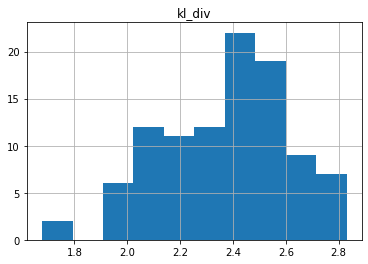

In [6]:
analysis.results_df.hist("kl_div")

In [7]:
config = analysis.best_result["config"]
model = models.seiird(**config)

In [8]:
covid_data_india_by_state = data_utils.load_covid_data_india()
covid_data_mh = covid_data_india_by_state.get(state)

In [9]:
def plot_covid_data_state(covid_df: Dict[str, pd.DataFrame], state: str, start_date=None):
    state_data = covid_df[state]
    if start_date is not None:
        state_data = covid_df[state].loc[covid_df[state].Date > start_date]
    ax = state_data.plot(x="Date", y=["Confirmed", "Cured", "Deaths"], figsize=(12, 8), title=state)
    ax.minorticks_on()
    ax.grid(True, which='major', linestyle='-', linewidth=0.25, axis='both', alpha=0.85, color="black")
    ax.grid(True, which='minor', linestyle='-.', linewidth=0.25, axis='both', alpha=0.7)

In [10]:
start_mh = covid_data_mh[covid_data_mh.Date == start_date].iloc[-1]
I0 = int(start_mh.Confirmed - (start_mh.Cured + start_mh.Deaths))
R0 = (start_mh.Cured)
D0 = start_mh.Deaths

In [19]:
model.simulate(
    timesteps=covid_data_mh[covid_data_mh.Date >= start_date].shape[0] - 1 + 60,
    t_min=1,
    start_date=start_date.date(),
    S=MH_pop-I0,
    E=0,
    Is=int(I0*config["p_a"]),
    Ia=int(I0*(1 - config["p_a"])),
    R=R0,
    D=D0
)

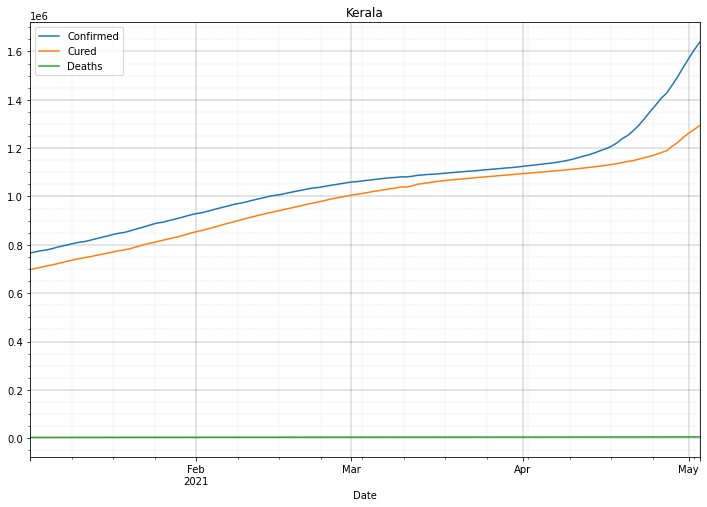

In [20]:
plot_covid_data_state(covid_data_india_by_state, state=state, start_date=start_date)

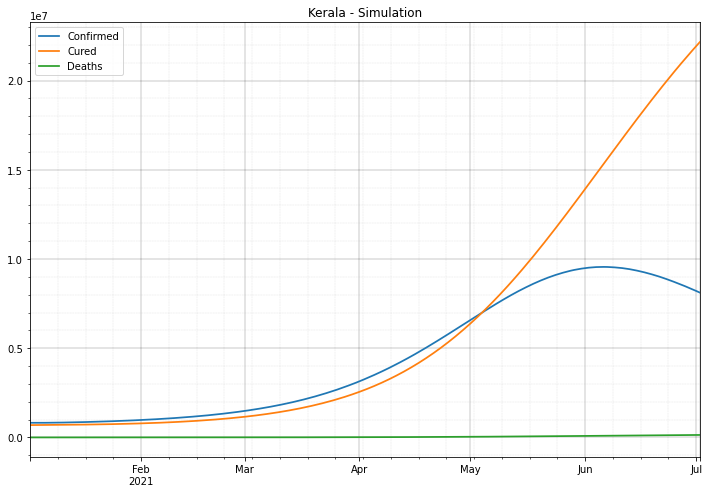

In [21]:
res = pd.DataFrame({
    "Confirmed": model.Ia + model.Is + start_mh.Confirmed,
    "Cured": model.R,
    "Deaths": model.D
})
ax1 = res.plot(figsize=(12, 8), linewidth=1.75, title=f"{state} - Simulation")
ax1.legend(['Confirmed', 'Cured', 'Deaths'])
ax1.minorticks_on()
ax1.grid(True, which='major', linestyle='-', linewidth=0.25, axis='both', alpha=0.85, color="black")
ax1.grid(True, which='minor', linestyle='-.', linewidth=0.25, axis='both', alpha=0.7)

In [14]:
config

{'beta': 0.6464069508157451,
 'p_a': 0.3900861169183053,
 'r_b': 0.47323538948270055,
 'eps': 0.08162391443796982,
 'mu': 0.033575158323300026,
 'rho': 0.0007807946564058593,
 'p_d': 0.010174455414678006}

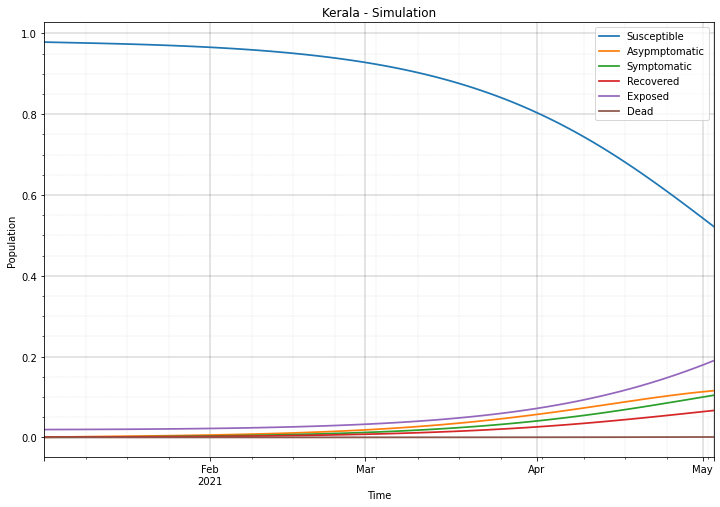

In [15]:
ax0 = model.plot(normed=True, figsize=(12, 8), linewidth=1.75, title=f"{state} - Simulation")
ax0.legend(['Susceptible', 'Asypmptomatic', 'Symptomatic', 'Recovered', 'Exposed', 'Dead'])